# EDA POS_CASH_balance
In this analysis, we explore the POS_CASH_balance data to compare loan usage patterns between defaulters and non-defaulters. The data reveals that POS and cash loans generally have smaller outstanding amounts, therefore, have shorter durations (mostly <= 2 years), with Days Past Due (DPD) mostly 0. Defaulters tend to have more future installments to pay compared to non-defaulters, who typically maintain consistent payment behavior.


In [1]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Read files

In [2]:
pos_cash = pd.read_csv(r'D:\python\visualize\final_project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_POS_CASH_balance.csv')
pos_cash.head()

,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,1803195,-31,48.0,45.0,Active,0,0,185279
1,1803195,-17,48.0,31.0,Active,0,0,185279
2,1803195,-21,48.0,35.0,Active,0,0,185279
3,1803195,-8,48.0,21.0,Active,0,0,185279
4,1803195,-4,48.0,17.0,Active,0,0,185279


In [3]:
train = pd.read_csv(r'D:\python\visualize\final_project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv')

In [4]:
print(f'The shape of POS_CASH_balance.csv is: {pos_cash.shape}')
print('-'*100)
print(f'Number of unique SK_ID_PREV in POS_CASH_balance.csv are: {len(pos_cash.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in POS_CASH_balance.csv are: {len(pos_cash.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: {len(set(train.SK_ID_CURR.unique()).intersection(set(pos_cash.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Number of duplicate values in POS_CASH_balance: {pos_cash.shape[0] - pos_cash.duplicated().shape[0]}')
print('-'*100)
display(pos_cash.head())

The shape of POS_CASH_balance.csv is: (8543375, 8)
----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in POS_CASH_balance.csv are: 800337
Number of unique SK_ID_CURR in POS_CASH_balance.csv are: 289444
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: 231531
----------------------------------------------------------------------------------------------------
Number of duplicate values in POS_CASH_balance: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR
0,1803195,-31,48.0,45.0,Active,0,0,185279
1,1803195,-17,48.0,31.0,Active,0,0,185279
2,1803195,-21,48.0,35.0,Active,0,0,185279
3,1803195,-8,48.0,21.0,Active,0,0,185279
4,1803195,-4,48.0,17.0,Active,0,0,185279


# Checking missing values

In [5]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [6]:
pos_cash.isna().sum()

SK_ID_PREV                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           21863
CNT_INSTALMENT_FUTURE    21878
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
SK_ID_CURR                   0
dtype: int64

In [7]:
print('-'*100)
print("Columns with NaN values and their percentages:")
POS_CASH_nan = nan_df_create(pos_cash)
display(POS_CASH_nan[POS_CASH_nan.percent != 0])
print('-'*100)
del POS_CASH_nan

----------------------------------------------------------------------------------------------------
Columns with NaN values and their percentages:


,column,percent
3,CNT_INSTALMENT_FUTURE,0.256081
2,CNT_INSTALMENT,0.255906


----------------------------------------------------------------------------------------------------


- There are only 2 columns which contain NaN values of the 8 columns from POS_CASH_balance. These columns are the Counts of Installments remaining and the term of the loan.
- These columns also contain very minimal proportion of NaN values, i.e only 0.26%%, so it is also not of much concern.

In [8]:
pos_cash_merged = pd.merge(pos_cash,train[['TARGET','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')


In [9]:
pos_cash_merged.head()

,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,SK_ID_CURR,TARGET
0,1803195,-31,48.0,45.0,Active,0,0,185279,0.0
1,1803195,-17,48.0,31.0,Active,0,0,185279,0.0
2,1803195,-21,48.0,35.0,Active,0,0,185279,0.0
3,1803195,-8,48.0,21.0,Active,0,0,185279,0.0
4,1803195,-4,48.0,17.0,Active,0,0,185279,0.0


In [10]:
pos_cash_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8543375 entries, 0 to 8543374
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   MONTHS_BALANCE         int64  
 2   CNT_INSTALMENT         float64
 3   CNT_INSTALMENT_FUTURE  float64
 4   NAME_CONTRACT_STATUS   object 
 5   SK_DPD                 int64  
 6   SK_DPD_DEF             int64  
 7   SK_ID_CURR             int64  
 8   TARGET                 float64
dtypes: float64(3), int64(5), object(1)
memory usage: 586.6+ MB


# Correlation matrix

In [11]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

----------------------------------------------------------------------------------------------------


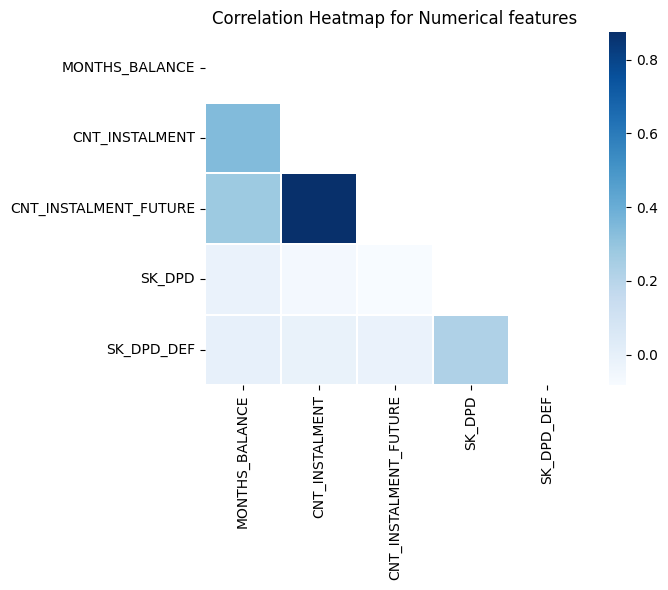

----------------------------------------------------------------------------------------------------


In [12]:
# Dropping non-numeric columns
pos_cash_merged_numeric = pos_cash_merged.select_dtypes(include=[np.number])

corr_mat = correlation_matrix(pos_cash_merged_numeric, ['SK_ID_CURR','SK_ID_PREV'], figsize = (7,6))
corr_mat.plot_correlation_matrix()

In [13]:
#Seeing the top columns with highest phik-correlation with the target variable in POS_CASH_balance table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'MONTHS_BALANCE']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT']
interval columns not set, guessing: ['TARGET', 'CNT_INSTALMENT_FUTURE']
interval columns not set, guessing: ['TARGET', 'SK_DPD']
interval columns not set, guessing: ['TARGET', 'SK_DPD_DEF']
----------------------------------------------------------------------------------------------------
Columns with highest values of Phik-correlation with Target Variable are:


,Column Name,Phik-Correlation
2,CNT_INSTALMENT_FUTURE,0.032245
1,CNT_INSTALMENT,0.029821
0,MONTHS_BALANCE,0.026539
3,SK_DPD,0.008729
4,SK_DPD_DEF,0.007073


----------------------------------------------------------------------------------------------------


- From the heatmap of correlation matrix, we one set of moderately correlated features, which are: CNT_INSTALMENT and CNT_INSTALMENT_FUTURE.
- The correlation of features with Target is very low, this shows the absence of a linear relationship between the feature and the target variable.

# Plot distribution for each feature

In [14]:
def draw_distribution(x, title,c):
    fig, ax = plt.subplots(2,1,figsize=(20,10))

    sns.distplot(x,ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')

    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')

    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

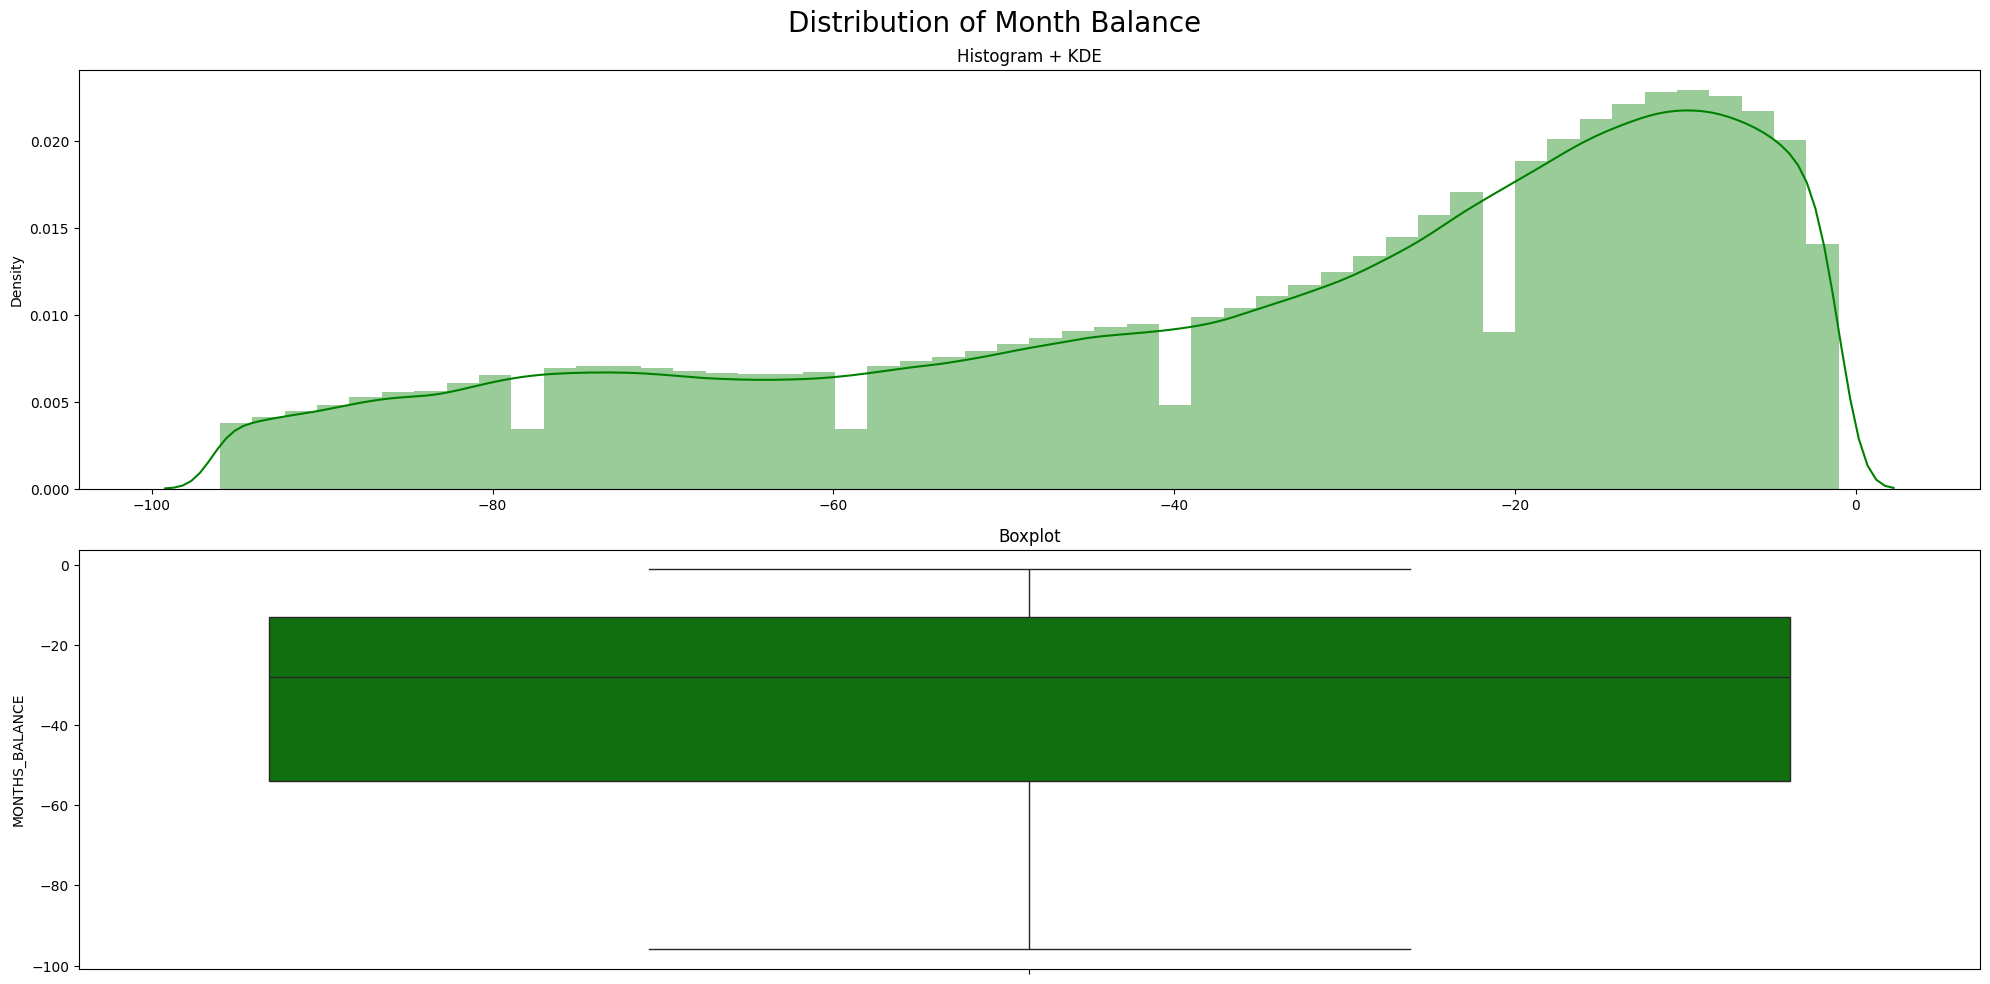

In [15]:
# distribution of MONTH_BALANCE
draw_distribution(pos_cash_merged['MONTHS_BALANCE'],'Distribution of Month Balance',"g")

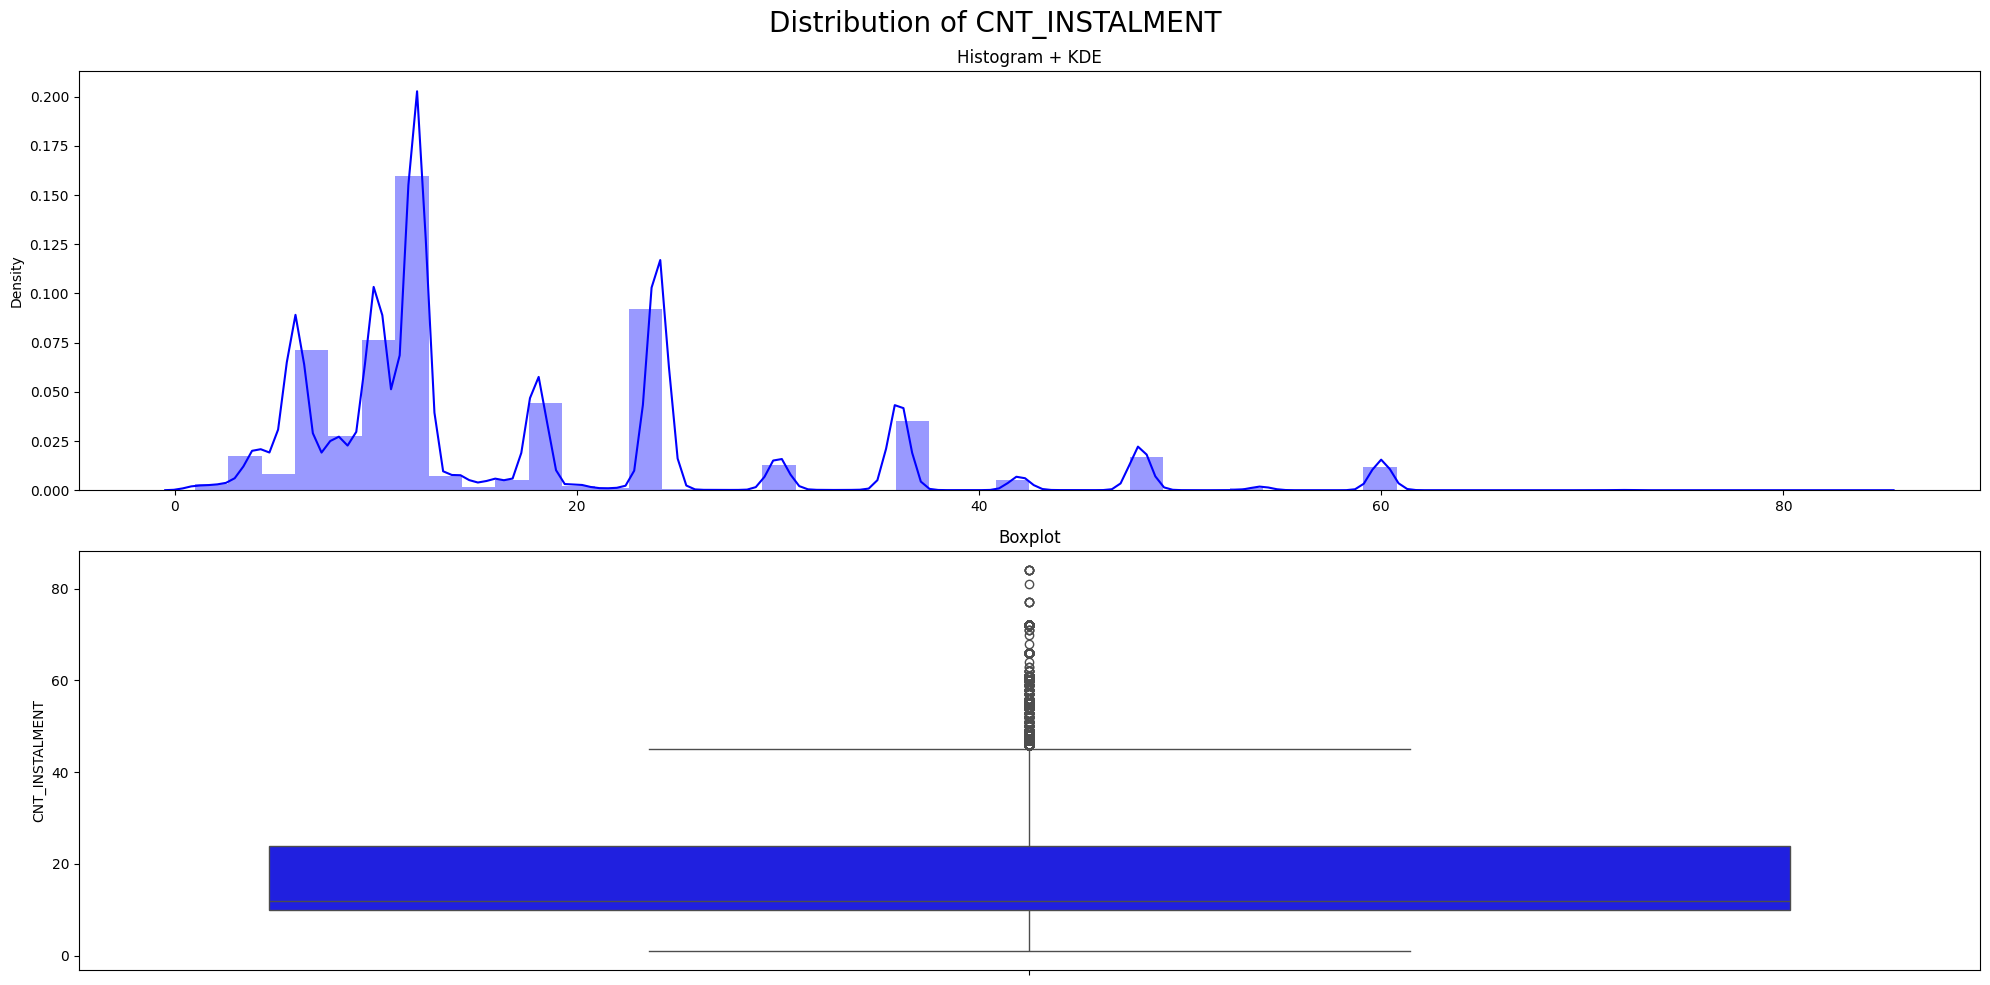

In [16]:
# distribution of CNT_INSTALMENT (term of previous credit in months)
draw_distribution(pos_cash_merged['CNT_INSTALMENT'],'Distribution of CNT_INSTALMENT',"b")

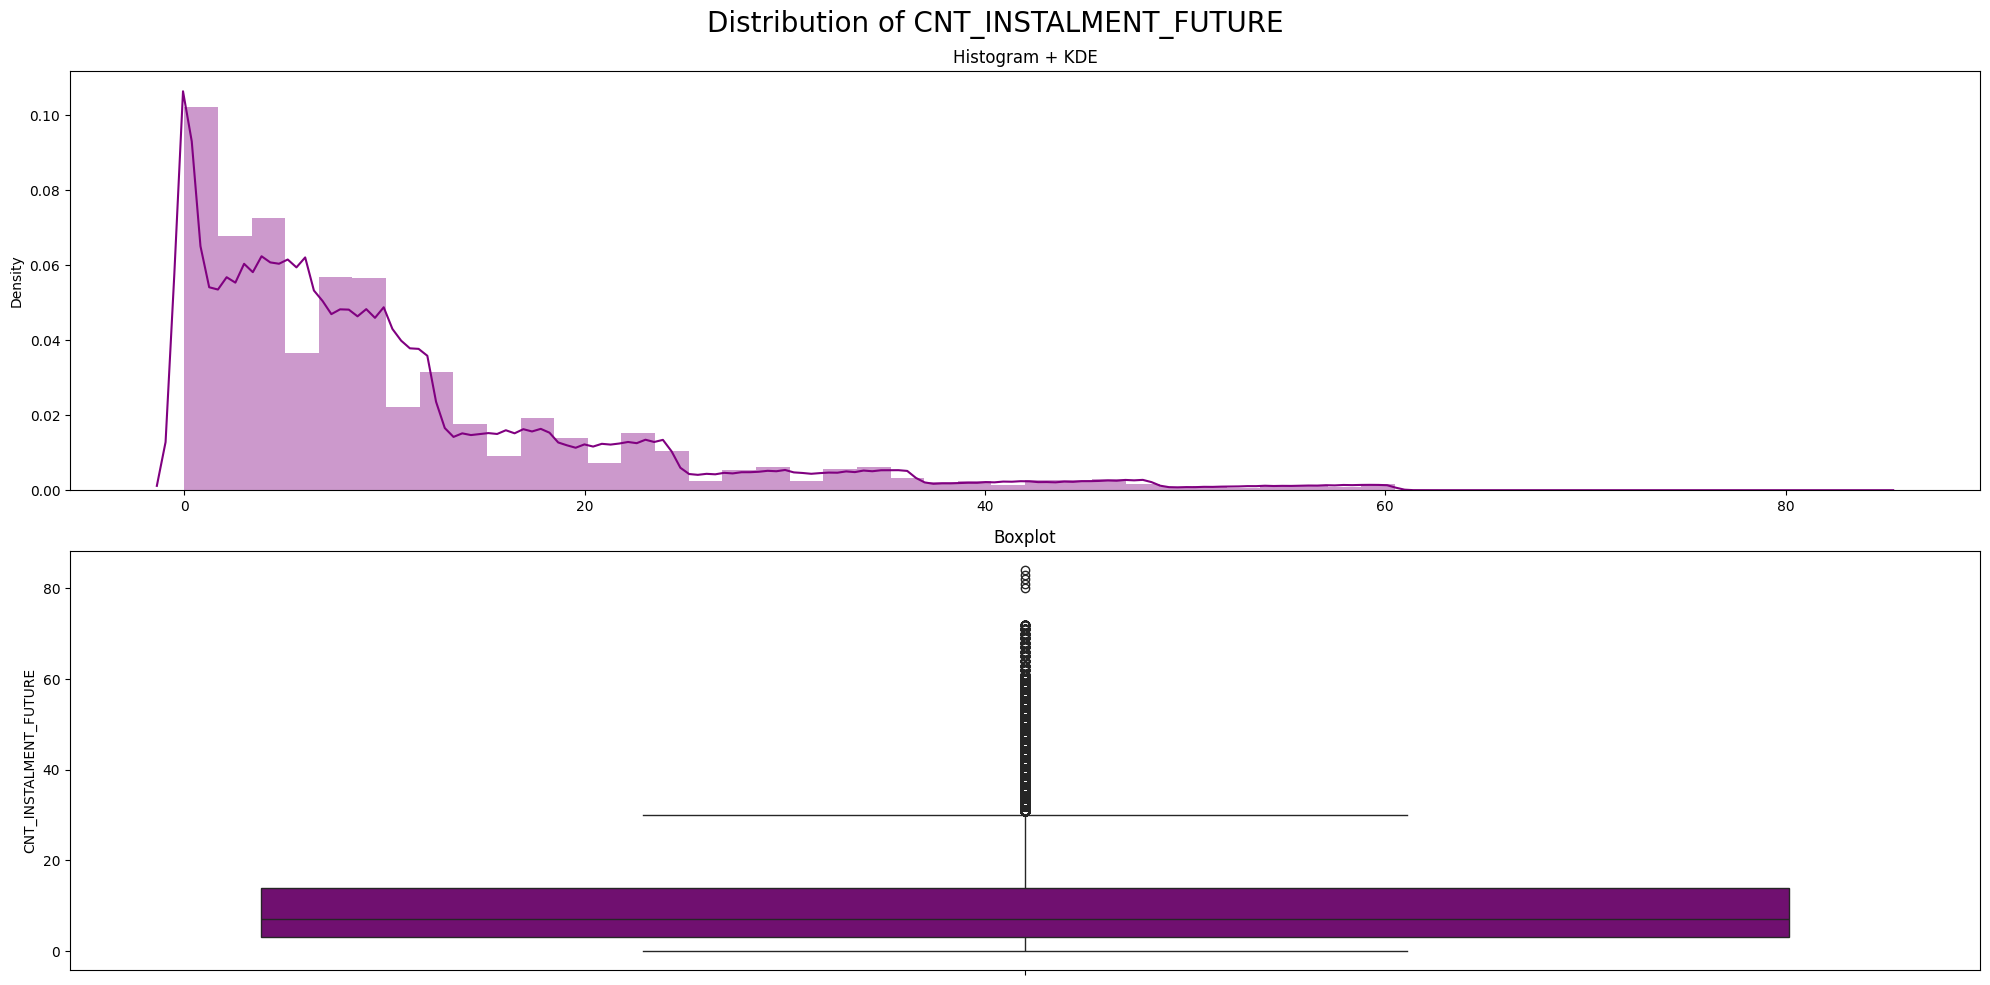

In [17]:
# distribution of CNT_INSTALMENT_FUTURE (left to pay on the previous credit)
draw_distribution(pos_cash_merged['CNT_INSTALMENT_FUTURE'],'Distribution of CNT_INSTALMENT_FUTURE',"purple")

we can see that, the POS_CASH loan tends to be short (almost < 2 years)

In [18]:
pos_cash_merged['SK_DPD'].value_counts(normalize = True)*100

SK_DPD
0       96.967159
1        0.220592
2        0.175633
3        0.146769
4        0.125899
          ...    
3731     0.000012
3641     0.000012
3580     0.000012
3488     0.000012
3059     0.000012
Name: proportion, Length: 3358, dtype: float64

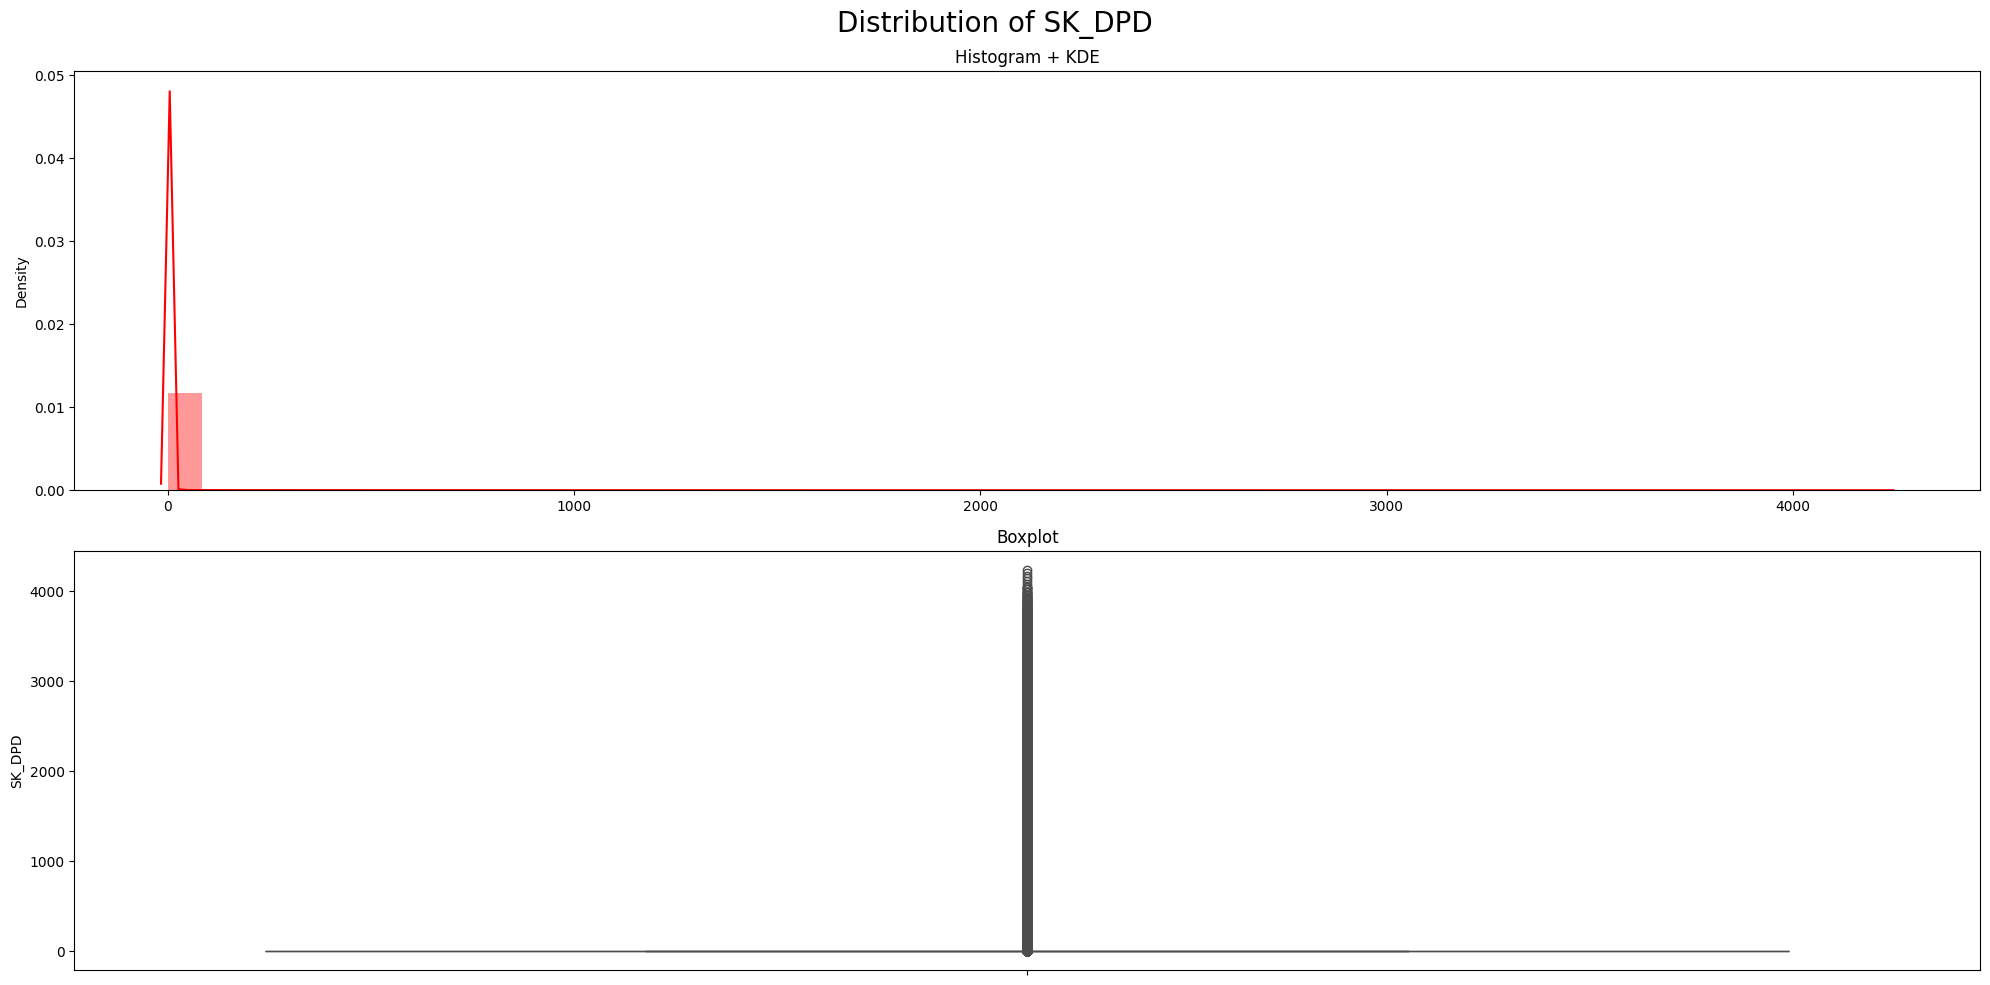

In [19]:
# distribution of SK_DPD (day past due during the month)
draw_distribution(pos_cash_merged['SK_DPD'],'Distribution of SK_DPD',"r")

đa số là không quá hạn 

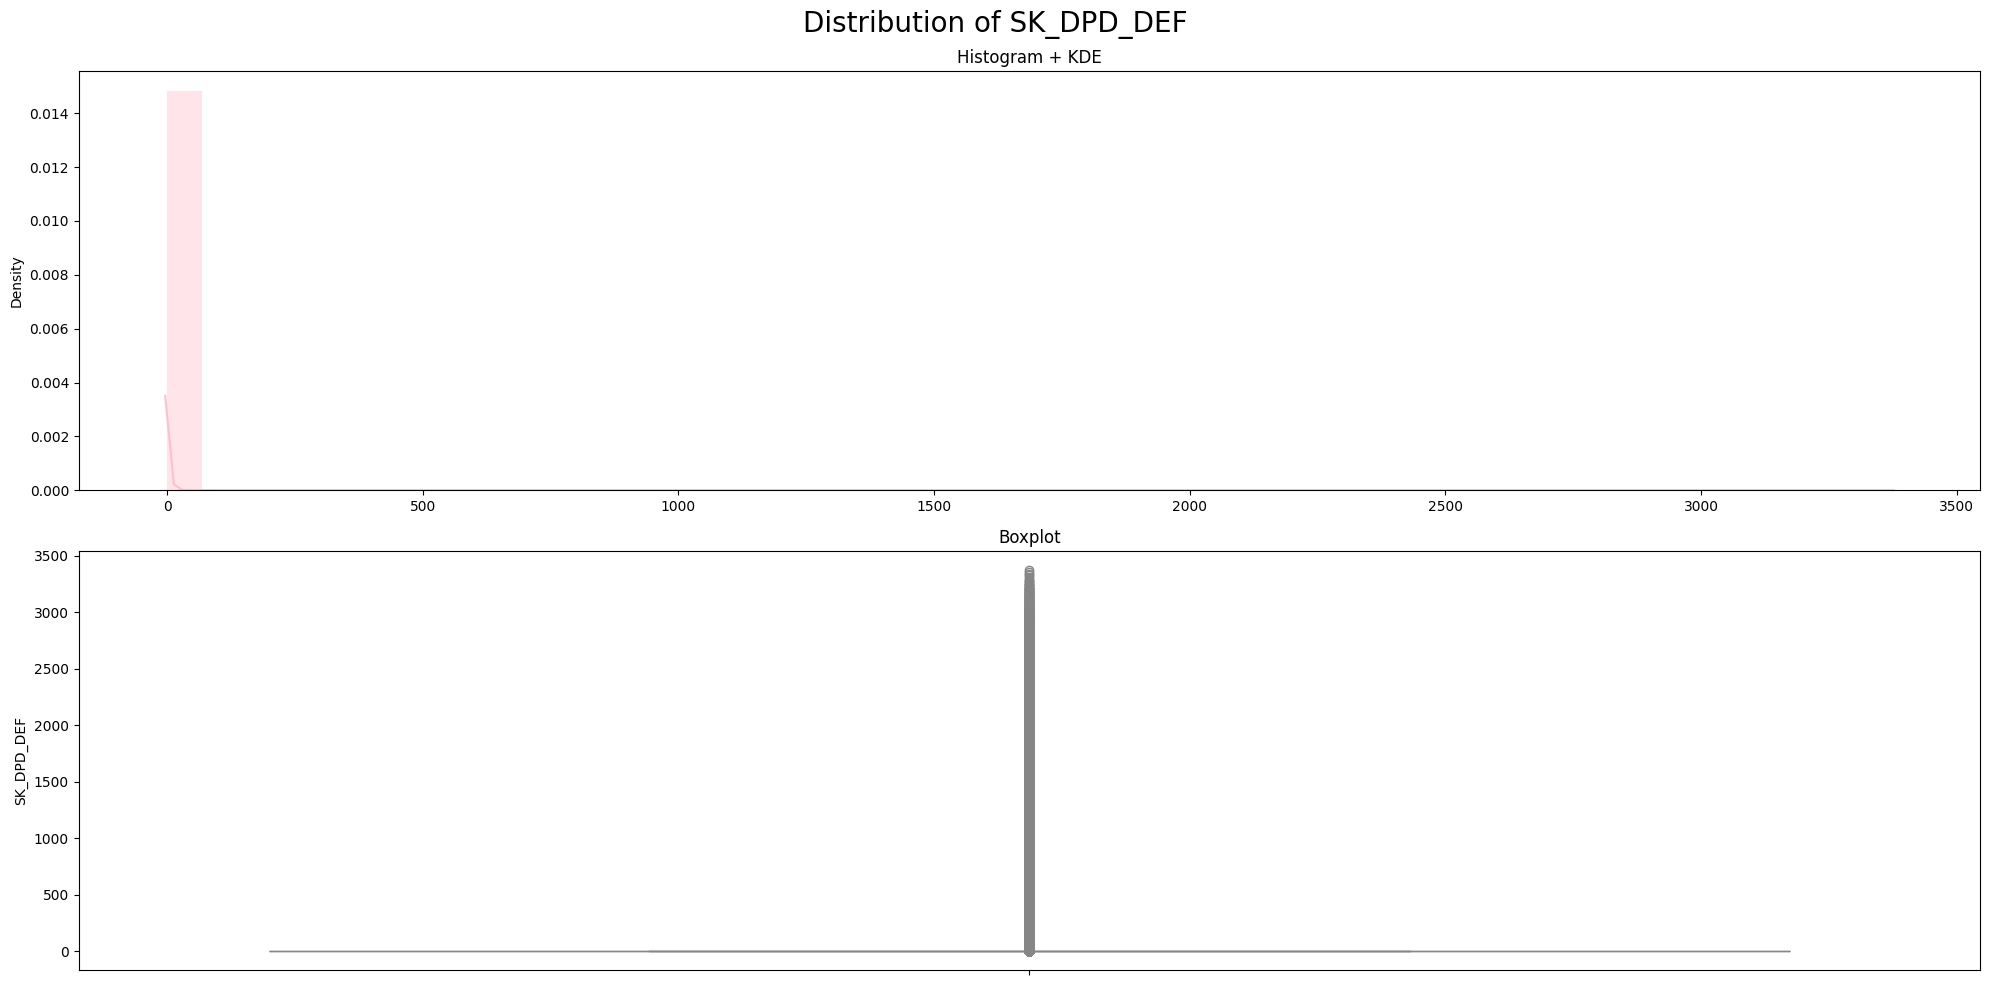

In [20]:
# distribution of SK_DPD_DEF (ngày trễ hạn nhưng loại trừ các khoản nợ nhỏ)
draw_distribution(pos_cash_merged['SK_DPD_DEF'],'Distribution of SK_DPD_DEF',"pink")

In [21]:
pos_cash_merged.drop(['SK_ID_PREV'], axis = 1, inplace = True)

# Numerical variables

Plotting 5 columns: ['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF']


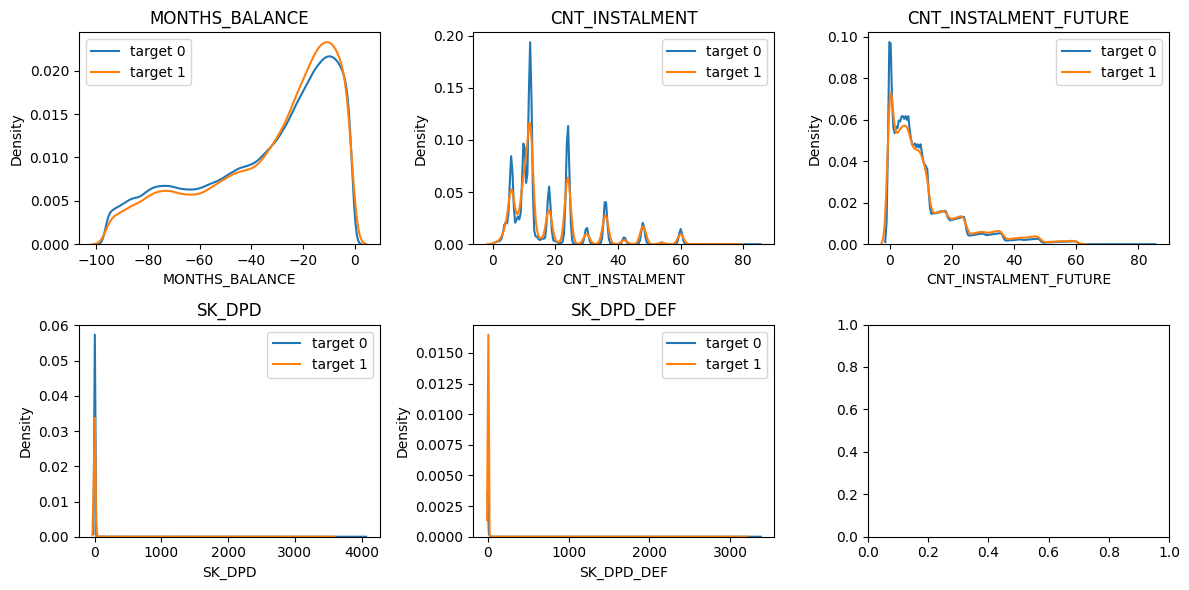

In [25]:
# Plot the distribution of the numerical features with hue = target
cols_to_plot = pos_cash_merged.drop(columns = ["NAME_CONTRACT_STATUS"]).var()[pos_cash_merged.drop(columns = ["NAME_CONTRACT_STATUS"]).var() > 0.1].index.tolist()
cols_to_plot.remove('SK_ID_CURR')
print(f'Plotting {len(cols_to_plot)} columns: {cols_to_plot}')
ncol, nrow = 3, len(cols_to_plot)//3 + 1
fig, ax = plt.subplots(nrow, ncol, figsize=(12, 6))

for i, col in enumerate(cols_to_plot):
    # kde plot
    sns.kdeplot(pos_cash_merged.loc[pos_cash_merged['TARGET'] == 0, col], label='target 0', ax=ax[i//ncol, i%ncol])
    sns.kdeplot(pos_cash_merged.loc[pos_cash_merged['TARGET'] == 1, col], label='target 1', ax=ax[i//ncol, i%ncol])
    ax[i//ncol, i%ncol].set_title(col)
    ax[i//ncol, i%ncol].legend()

plt.tight_layout()
plt.show()

- Since non-defaulters have higher peak at 0 in SK_DPD, we can say that non-defaulters tend to pay on time more than defaulters.

### CNT_INSTALMENT_FUTURE



In [31]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='blue')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='red')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

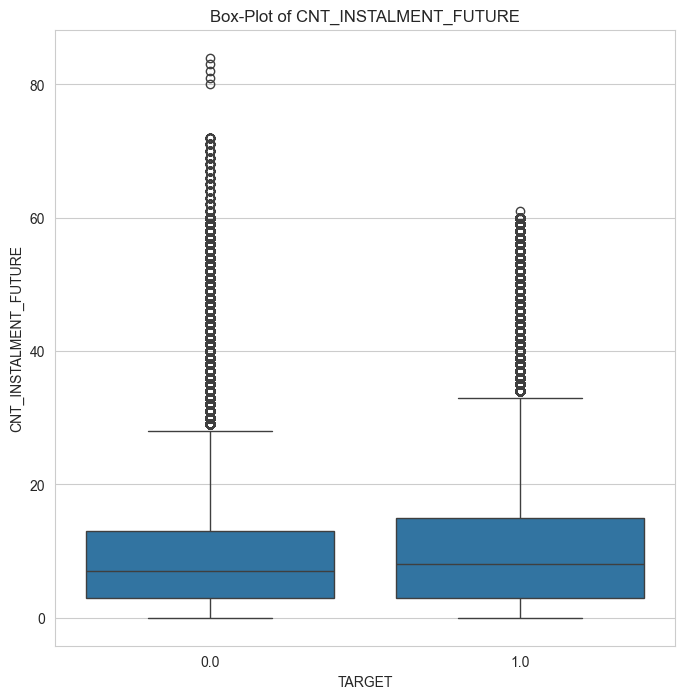

In [32]:
plot_continuous_variables(pos_cash_merged, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (8,8))
del pos_cash_merged

Looking at the above box-plot for CNT_INSTALMENT_FUTURE, we see that the percentile values>50% for Defaulters are usually higher than those of Non-Defaulters. Even the upper limit whisker for Defaulters is higher than that of Non-Defaulters. This suggests that the Defaulters tend to have more number of Installments remaining on their previous credits as compared to Non-Defaulters.

# Categorical variables

In [28]:
def plot_normalized_stacked_bar_chart(data, category_col, binary_col):
    '''
    input: 
        data: dataframe
        category_col: categorycal column
        binary_Col: target column
    '''
    grouped = data.groupby(category_col)[binary_col].value_counts(normalize=True).unstack()
    grouped.plot(kind='bar', stacked=True)
    plt.title('Normalized Stacked Bar Chart')
    plt.xlabel(category_col)
    plt.ylabel('Percentage')
    plt.show()

In [29]:
pos_cash_merged['NAME_CONTRACT_STATUS'].value_counts()

NAME_CONTRACT_STATUS
Active                   7818577
Completed                 634872
Signed                     74625
Demand                      6110
Returned to the store       4591
Approved                    4221
Amortized debt               365
Canceled                      12
XNA                            2
Name: count, dtype: int64

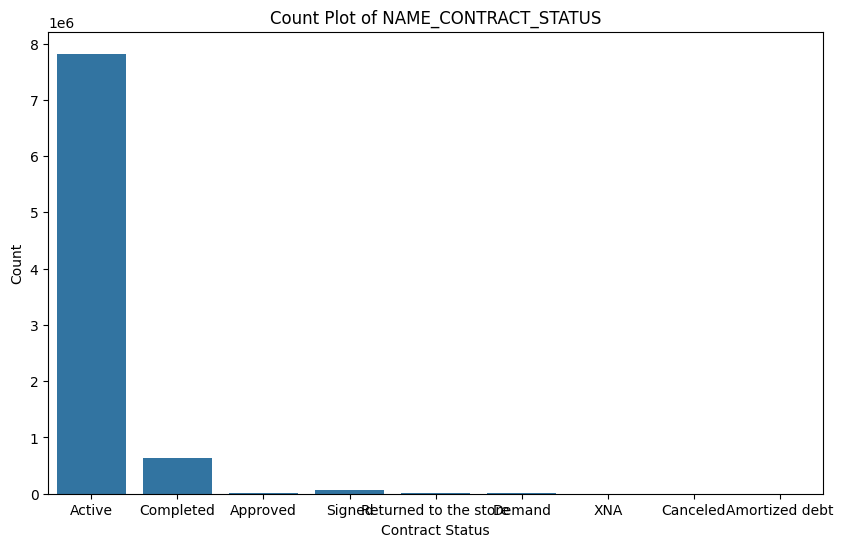

In [50]:
plt.figure(figsize=(10, 6))
sns.countplot(data=pos_cash_merged, x='NAME_CONTRACT_STATUS')
plt.title('Count Plot of NAME_CONTRACT_STATUS')
plt.xlabel('Contract Status')
plt.ylabel('Count')
plt.show()

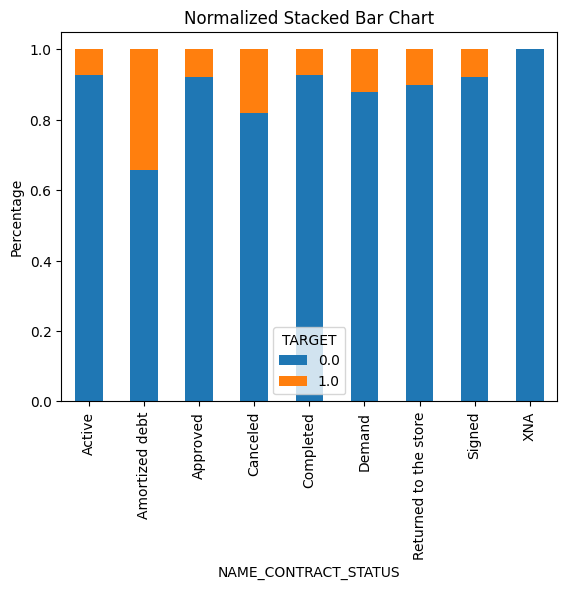

In [30]:
plot_normalized_stacked_bar_chart(pos_cash_merged,"NAME_CONTRACT_STATUS", "TARGET")


- The defaulters tend to have cancled and amortized debt contracts status.